In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/grocery-store-sales-dataset-in-2025-1900-record")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'grocery-store-sales-dataset-in-2025-1900-record' dataset.
Path to dataset files: /kaggle/input/grocery-store-sales-dataset-in-2025-1900-record


In [5]:
import os
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values(['aisle','transaction_date'])

In [15]:
df = df.groupby(['transaction_date','aisle']).size().reset_index(name='sales')


In [16]:
WINDOW = 7
X_all, y_all = [], []

for aisle in df['aisle'].unique():
    sales = df[df['aisle']==aisle]['sales'].values.reshape(-1,1)
    if len(sales) <= WINDOW:
        continue
    scaler = MinMaxScaler()
    sales_scaled = scaler.fit_transform(sales)
    for i in range(len(sales_scaled)-WINDOW):
        X_all.append(sales_scaled[i:i+WINDOW])
        y_all.append(sales_scaled[i+WINDOW])


In [17]:
X_all = np.array(X_all)
y_all = np.array(y_all)

split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW,1)),
    LSTM(32),
    Dense(1)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer="adam", loss="mse")

model.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0640 - val_loss: 0.0339
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596 - val_loss: 0.0327
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0684 - val_loss: 0.0331
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0658 - val_loss: 0.0326
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0678 - val_loss: 0.0332
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0653 - val_loss: 0.0326
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0689 - val_loss: 0.0331
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0604 - val_loss: 0.0339
Epoch 9/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0598 - val_loss: 0.0330
Epoch 10/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0654 - val_loss: 0.0329
Epoch 11/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0657 - val_loss: 0.0333


In [20]:
aisle_to_predict = df['aisle'].unique()[0]
prediction = predict_next_day(aisle_to_predict)
print(f"Predicted next-day sales for aisle '{aisle_to_predict}': {round(prediction)} units")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted next-day sales for aisle 'Beverages': 1 units


In [19]:
model.save("next_day_sales_model.h5")

def predict_next_day(aisle_name):
    sales = df[df['aisle']==aisle_name]['sales'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    sales_scaled = scaler.fit_transform(sales)
    last_window = sales_scaled[-WINDOW:]
    pred = model.predict(last_window.reshape(1,WINDOW,1))
    return float(scaler.inverse_transform(pred)[0][0])

print("Example Prediction:", predict_next_day(df['aisle'].unique()[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
Example Prediction: 1.080492377281189


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


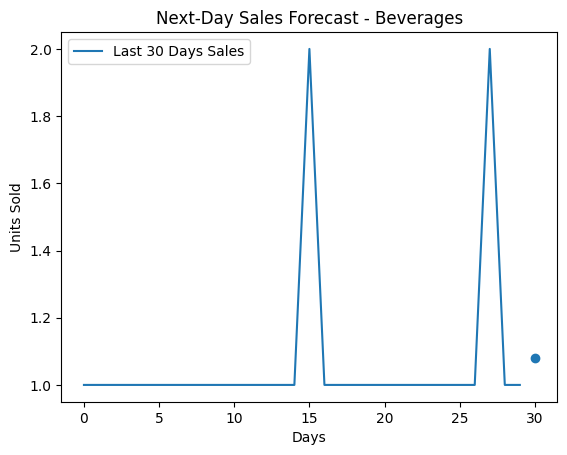

In [21]:
import matplotlib.pyplot as plt

aisle_to_plot = df['aisle'].unique()[0]
sales = df[df['aisle']==aisle_to_plot]['sales'].values

pred = predict_next_day(aisle_to_plot)

plt.figure()
plt.plot(sales[-30:], label="Last 30 Days Sales")
plt.scatter(len(sales[-30:]), pred)
plt.legend()
plt.title(f"Next-Day Sales Forecast - {aisle_to_plot}")
plt.xlabel("Days")
plt.ylabel("Units Sold")
plt.show()
